# Mock mid-term exam: April 2023

The objectives of this mock mid-term exam are:
- to gain acquaintance with the type of programming questions that you will be asked during the mid-term exam
- Becoming more comfortable in performing Input-Output analysis calculations

In [1]:
# Import modules
from itertools import chain
import pandas as pd
import numpy as np

# Set pandas number format
pd.options.display.float_format = '{:,.2f}'.format

## Data preparation
### Import population data

In [2]:
# Set file path
FILEPATH = "../data/exiobase/EXIOBASE_PopulationGDP_1995_2019.xlsx"

# Load Eurostat data
population_per_region = pd.read_excel(
    FILEPATH, 
    engine = "openpyxl", 
    sheet_name = 'Population',  # None = all sheets
    header = 0,  # [,] -> multiindex for columns
    index_col = 2,  # [,]  -> multiindex for index
    skipfooter = 0,
)

# Clean population data
YEAR = 'y2015'
population_per_region = population_per_region[YEAR]
population_per_region

AT       8,473,786.00
BE      11,195,138.00
BG       7,120,539.21
CY       1,164,103.44
CZ      10,521,468.00
DE      80,621,788.00
DK       5,613,706.00
EE       1,324,612.00
ES      46,647,421.00
FI       5,439,407.00
FR      66,028,467.00
GR      11,032,328.00
HR       4,252,700.00
HU       9,897,247.00
IE       4,687,646.15
IT      59,831,093.00
LT       2,956,121.00
LU         554,120.36
LV       2,013,385.00
MT         423,282.00
NL      16,804,224.00
PL      38,530,725.00
PT      10,459,806.00
RO      19,963,581.00
SE       9,785,362.30
SI       2,060,484.00
SK       5,414,095.00
UK      64,097,085.00
US     322,483,028.66
JP     127,338,621.00
CN   1,357,380,000.00
CA      35,864,985.91
KR      50,219,669.00
BR     204,389,199.69
IN   1,277,307,601.88
MX     124,791,280.22
RU     143,499,861.00
AU      23,595,831.09
CH       8,243,919.79
TR      76,438,787.08
TW      24,301,000.00
NO       5,186,382.22
ID     254,887,930.18
ZA      52,981,991.00
WA     922,542,740.32
WL     299

### Download and import exiobase data - year 2015, industry-by-industry format

In [3]:
# Set file directories
dir_path = "../data/exiobase/_ixi/IOT_2015_ixi/"

The Exiobase folder has the following structure:  

```
├── impacts  
│   ├── F_Y.txt  
│   ├── F.txt  
│   └── ...
├── satellite  
│   ├── F_Y.txt  
│   ├── F.txt  
│   └── ...
├── A.txt
├── finaldemands.txt  
├── industries.txt  
├── products.txt  
├── unit.txt  
├── x.txt  
├── Y.txt  
└── Z.txt  
```

In [4]:
# Import A, Y, F and F_Y (from SATELLITE)
# ! 'A' is a large datasets, mind load time
A = pd.read_csv(f'{dir_path}A.txt', delimiter="\t", header=[0,1], index_col=[0,1])
Y = pd.read_csv(f'{dir_path}Y.txt', delimiter="\t", header=[0,1], index_col=[0,1])
# ! we use the satellite folder this time because we will look at uncharacterized stressors (CO2 emission)
F = pd.read_csv(f'{dir_path}satellite/F.txt', delimiter="\t", header=[0,1], index_col=[0])
F_y = pd.read_csv(f'{dir_path}satellite/F_Y.txt', delimiter="\t", header=[0,1], index_col=[0])
F_unit = pd.read_csv(f'{dir_path}satellite/unit.txt', delimiter="\t", header=0, index_col=[0])

### Get labels

In [5]:
# get multiindex
region_and_sector_labels = A.index

# get each level using  'get_level_values()'
region_labels = A.index.get_level_values(level=0).unique()
sector_labels = A.index.get_level_values(level=1).unique()

# Make necessary change to aovid ValueError below
population_per_region.rename(index={'UK': 'GB'}, inplace=True)
population_per_region.reindex(index = region_labels)

# Sanity check: ensure population data covers every region of exiobase
if not set(region_labels) & set(population_per_region.index) == set(region_labels):
    idx_only_in_exiobase = set(region_labels) - set(population_per_region.index)
    idx_only_in_pop_data = set(population_per_region.index) - set(region_labels)
    # raise ValueError(
    print(
        "Missing region:\n"
        f"{list(idx_only_in_exiobase)} (EXIOBASE) vs "
        f"{list(idx_only_in_pop_data)} (Population data)"
    )

## Input-Output calculations
### Leontief inverse

In [6]:
# Create an identity matrix the same order
Id = np.identity(len(region_and_sector_labels))

# Compute leontief inverse matrix in the Demand-pull model
L_values = np.linalg.inv((Id - A))
L = pd.DataFrame(
    data=L_values, 
    index=region_and_sector_labels, 
    columns=region_and_sector_labels
)

# we also save LY to avoid repeating calculations
LY = L @ Y

### Product output X

In [7]:
# Compute using L
x = LY.sum(axis=1)
x

region  sector                                             
AT      Cultivation of paddy rice                                  0.00
        Cultivation of wheat                                     331.35
        Cultivation of cereal grains nec                         760.60
        Cultivation of vegetables, fruit, nuts                 1,416.38
        Cultivation of oil seeds                                 146.71
                                                                 ...   
WM      Activities of membership organisation n.e.c. (91)     14,967.30
        Recreational, cultural and sporting activities (92)   45,522.75
        Other service activities (93)                         25,559.13
        Private households with employed persons (95)          5,990.50
        Extra-territorial organizations and bodies                 0.00
Length: 7987, dtype: float64

### Extension intensity

In [8]:
# compute extension intensity
f = F / x.T
f = f.replace([np.inf, -np.inf, np.nan], 0)  # ! don't forget to replace

# Uncomment to display
f

region                                                                    AT  \
sector                                             Cultivation of paddy rice   
stressor                                                                       
Taxes less subsidies on products purchased: Total                       0.00   
Other net taxes on production                                           0.00   
Compensation of employees; wages, salaries, & e...                      0.00   
Compensation of employees; wages, salaries, & e...                      0.00   
Compensation of employees; wages, salaries, & e...                      0.00   
...                                                                      ...   
Energy Carrier Net TMAR                                                 0.00   
Energy Carrier Net TOTH                                                 0.00   
Energy Carrier Net TRAI                                                 0.00   
Energy Carrier Net TROA                                                 0.00   
Energy Carrier Net LOSS                                                 0.00   

region                                                                   \
sector                                             Cultivation of wheat   
stressor                                                                  
Taxes less subsidies on products purchased: Total                  0.02   
Other net taxes on production                                     -0.04   
Compensation of employees; wages, salaries, & e...                 0.00   
Compensation of employees; wages, salaries, & e...                 0.04   
Compensation of employees; wages, salaries, & e...                 0.01   
...                                                                 ...   
Energy Carrier Net TMAR                                            0.00   
Energy Carrier Net TOTH                                            0.00   
Energy Carrier Net TRAI                                            0.00   
Energy Carrier Net TROA                                            4.17   
Energy Carrier Net LOSS                                            0.00   

region                                                                               \
sector                                             Cultivation of cereal grains nec   
stressor                                                                              
Taxes less subsidies on products purchased: Total                              0.01   
Other net taxes on production                                                 -0.04   
Compensation of employees; wages, salaries, & e...                             0.00   
Compensation of employees; wages, salaries, & e...                             0.04   
Compensation of employees; wages, salaries, & e...                             0.01   
...                                                                             ...   
Energy Carrier Net TMAR                                                        0.00   
Energy Carrier Net TOTH                                                        0.00   
Energy Carrier Net TRAI                                                        0.00   
Energy Carrier Net TROA                                                        0.25   
Energy Carrier Net LOSS                                                        0.00   

region                                                                                     \
sector                                             Cultivation of vegetables, fruit, nuts   
stressor                                                                                    
Taxes less subsidies on products purchased: Total                                    0.01   
Other net taxes on production                                                       -0.03   
Compensation of employees; wages, salaries, & e...                                   0.00   
Compensation of employees; wages, salaries, & e... 

## Question 1: Carbon footprint of the nations (18 points)

#### 1.1 What were the per capita carbon footprint of each of the 49 exiobase regions when considering only CO2 emissions in 2015? (8 points)

In [9]:
# select extension indicator
MASK = f.index.str.contains("CO2")
CO2 = f.loc[MASK].index
CO2

Index(['CO2 - combustion - air',
       'CO2 - non combustion - Cement production - air',
       'CO2 - non combustion - Lime production - air',
       'CO2 - agriculture - peat decay - air', 'CO2 - waste - biogenic - air',
       'CO2 - waste - fossil - air'],
      dtype='object', name='stressor')

$\text{e} = \text{f} \mathbf{L}\text{Y} + \text{F}_{y}$  

In [10]:
# CO2 footprint per region (total)
f_co2 = f.loc[CO2]
F_y_co2 = F_y.loc[CO2]
fLY_co2 = f_co2 @ LY

e_fp_co2 = fLY_co2 + F_y_co2

# Sanity check
if not (fLY_co2.shape == F_y_co2.shape):
    raise IndexError("shape error")

# Uncomment to display result
e_fp_co2

region                                                                                  AT  \
category                                       Final consumption expenditure by households   
stressor                                                                                     
CO2 - combustion - air                                                   52,320,461,879.96   
CO2 - non combustion - Cement production - air                              443,740,529.87   
CO2 - non combustion - Lime production - air                                149,622,168.44   
CO2 - agriculture - peat decay - air                                        150,126,169.03   
CO2 - waste - biogenic - air                                                 10,773,912.91   
CO2 - waste - fossil - air                                                      330,213.93   

region                                                                                                                               \
category                                       Final consumption expenditure by non-profit organisations serving households (NPISH)   
stressor                                                                                                                              
CO2 - combustion - air                                                           1,301,019,653.84                                     
CO2 - non combustion - Cement production - air                                      20,138,708.76                                     
CO2 - non combustion - Lime production - air                                         7,023,396.41                                     
CO2 - agriculture - peat decay - air                                                   682,208.55                                     
CO2 - waste - biogenic - air                                                           177,696.48                                     
CO2 - waste - fossil - air                                                               6,541.30                                     

region                                                                                      \
category                                       Final consumption expenditure by government   
stressor                                                                                     
CO2 - combustion - air                                                    7,473,422,450.30   
CO2 - non combustion - Cement production - air                              124,909,597.47   
CO2 - non combustion - Lime production - air                                 43,984,691.31   
CO2 - agriculture - peat decay - air                                          7,086,919.26   
CO2 - waste - biogenic - air                                                  1,456,918.03   
CO2 - waste - fossil - air                                                       48,247.98   

region                                                                        \
category                                       Gross fixed capital formation   
stressor                                                                       
CO2 - combustion - air                                     17,843,652,662.40   
CO2 - non combustion - Cement production - air              1,541,602,573.63   
CO2 - non combustion - Lime production - air                  570,643,189.57   
CO2 - agriculture - peat decay - air                           20,391,553.75   
CO2 - waste - biogenic - air                                    7,495,560.79   
CO2 - waste - fossil - air                                        277,735.25   

region                                                                 \
category                                       Changes in inventories   
stressor                                                                
CO2 - combustion - air                               1,071,281,997.30   
CO2 - non combustion - Cement production - air          19,642,551.58   
CO2 

In [11]:
# Keep regions (column level 0) and sum accross categories (column level 1)
e_fp_co2_regions = e_fp_co2.groupby('region', axis=1).sum()
e_fp_co2_regions = e_fp_co2_regions.reindex(columns=region_labels)  # groupby() reshuffles, so apply reindex()

# CO2 extensions per capita per region
e_fp_co2_pp_regions = e_fp_co2_regions / population_per_region

# Uncomment to display result
e_fp_co2_pp_regions

region,AT,BE,BG,CY,CZ,DE,DK,EE,ES,FI,...,TR,TW,NO,ID,ZA,WA,WL,WE,WF,WM
stressor,,,,,,,,,,,,,,,,,,,,,
CO2 - combustion - air,"9,442.04","11,192.14","4,818.60","9,373.30","9,393.36","11,301.25","11,417.78","11,150.58","5,953.24","10,031.52",...,"4,774.68","6,657.94","13,185.13","1,695.57","5,399.64","1,999.27","3,393.21","3,690.69",785.44,"6,176.42"
CO2 - non combustion - Cement production - air,253.73,355.65,166.47,373.28,132.00,197.94,193.74,182.35,194.22,158.00,...,272.73,146.44,267.07,122.21,119.57,51.26,128.38,86.44,61.87,274.81
CO2 - non combustion - Lime production - air,91.84,235.56,80.45,57.81,55.26,70.85,43.99,35.60,25.86,55.03,...,59.41,20.32,67.22,15.75,42.89,11.56,57.56,67.31,11.08,45.52
CO2 - agriculture - peat decay - air,21.48,22.29,5.48,9.47,11.04,25.71,17.11,5.84,16.72,41.21,...,29.21,46.01,15.75,9.00,4.51,1.88,5.09,1.10,0.82,15.23
CO2 - waste - biogenic - air,2.40,3.01,1.01,1.43,26.91,2.18,2.58,1.41,65.49,3.32,...,0.44,0.77,5.55,0.68,0.18,0.50,0.91,0.72,0.10,0.55
CO2 - waste - fossil - air,0.08,0.20,0.04,0.07,0.55,0.09,0.12,0.06,0.95,0.16,...,0.02,0.04,0.14,0.01,0.01,0.05,0.04,0.02,0.01,0.03


In [12]:
# aggregate CO2 extensions
e_fp_agg_co2_pp_regions = e_fp_co2_pp_regions.sum(axis=0)

# Display result 
e_fp_agg_co2_pp_regions

region
AT    9,811.57
BE   11,808.85
BG    5,072.06
CY    9,815.37
CZ    9,619.12
DE   11,598.03
DK   11,675.32
EE   11,375.83
ES    6,256.48
FI   10,289.24
FR    6,922.48
GR   12,511.01
HR    3,992.22
HU    5,451.14
IE   11,723.66
IT    7,667.74
LT    6,752.61
LU   23,166.44
LV    6,043.55
MT   12,926.64
NL   12,321.76
PL    7,399.38
PT    5,492.89
RO    3,829.16
SE    7,183.38
SI    7,526.13
SK    7,693.97
GB    9,769.44
US   18,518.33
JP   10,047.76
CN    6,435.54
CA   14,149.82
KR   12,219.83
BR    2,466.26
IN    1,629.17
MX    3,494.03
RU    7,964.16
AU   18,637.68
CH   11,225.80
TR    5,136.48
TW    6,871.53
NO   13,540.86
ID    1,843.22
ZA    5,566.81
WA    2,064.53
WL    3,585.20
WE    3,846.27
WF      859.33
WM    6,512.54
dtype: float64

<Axes: xlabel='region', ylabel='tonnes CO2 / capita'>

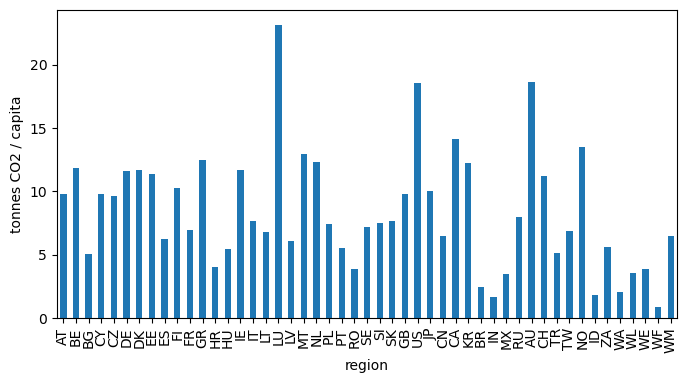

In [13]:
# Visualize
(e_fp_agg_co2_pp_regions/1e3).plot(
    figsize = (8,4),
    kind = 'bar',
    ylabel = "tonnes CO2 / capita",
)

# Check units are indeed in kg
# F_unit.loc[CO2]

#### 1.2 What were the per capita carbon footprint of each of the 49 regions in CO2eq when considering CH4, N2O, and CO2? (6 points)
Instruction: Please use 29.8 and 273 for GWP100 of CH4 and N2O, respectively.

In [14]:
# select extension indicator
# for CH4
MASK = f.index.str.contains("CH4")
CH4 = f.loc[MASK].index
# print(CH4)

# for N2O
MASK = f.index.str.contains("N2O")
N2O =  f.loc[MASK].index
# print(N2O)

# Combine all extensions indexes into a single index
GHG = list(set(chain(*[CO2, CH4, N2O])))
GHG = pd.Index(sorted(GHG))
print(GHG)

Index(['CH4 - agriculture - air', 'CH4 - combustion - air',
       'CH4 - non combustion - Extraction/production of (natural) gas - air',
       'CH4 - non combustion - Extraction/production of crude oil - air',
       'CH4 - non combustion - Mining of antracite - air',
       'CH4 - non combustion - Mining of bituminous coal - air',
       'CH4 - non combustion - Mining of coking coal - air',
       'CH4 - non combustion - Mining of lignite (brown coal) - air',
       'CH4 - non combustion - Mining of sub-bituminous coal - air',
       'CH4 - non combustion - Oil refinery - air', 'CH4 - waste - air',
       'CO2 - agriculture - peat decay - air', 'CO2 - combustion - air',
       'CO2 - non combustion - Cement production - air',
       'CO2 - non combustion - Lime production - air',
       'CO2 - waste - biogenic - air', 'CO2 - waste - fossil - air',
       'N2O - agriculture - air', 'N2O - combustion - air'],
      dtype='object')


In [15]:
# GHG emissions per region (total)
f_ghg = f.loc[GHG]
F_y_ghg = F_y.loc[GHG]
fLY_ghg = f_ghg @ L @ Y

# results per GHG
e_fp_ghg = fLY_ghg + F_y_ghg

# Sanity check
if e_fp_ghg.isna().any().any():
    raise ValueError("nan values in result")

# Uncomment to display result
e_fp_ghg

region                                                                                      AT  \
category                                           Final consumption expenditure by households   
CH4 - agriculture - air                                                         190,435,182.63   
CH4 - combustion - air                                                           22,341,375.86   
CH4 - non combustion - Extraction/production of...                               23,200,763.09   
CH4 - non combustion - Extraction/production of...                              118,137,173.63   
CH4 - non combustion - Mining of antracite - air                                    898,427.90   
CH4 - non combustion - Mining of bituminous coa...                               17,371,615.09   
CH4 - non combustion - Mining of coking coal - air                                5,060,346.29   
CH4 - non combustion - Mining of lignite (brown...                                  905,345.85   
CH4 - non combustion - Mining of sub-bituminous...                                1,920,163.09   
CH4 - non combustion - Oil refinery - air                                           716,405.36   
CH4 - waste - air                                                                99,487,013.39   
CO2 - agriculture - peat decay - air                                            150,126,169.03   
CO2 - combustion - air                                                       52,320,461,879.96   
CO2 - non combustion - Cement production - air                                  443,740,529.87   
CO2 - non combustion - Lime production - air                                    149,622,168.44   
CO2 - waste - biogenic - air                                                     10,773,912.91   
CO2 - waste - fossil - air                                                          330,213.93   
N2O - agriculture - air                                                          11,612,735.31   
N2O - combustion - air                                                            1,795,035.56   

region                                                                                                                                   \
category                                           Final consumption expenditure by non-profit organisations serving households (NPISH)   
CH4 - agriculture - air                                                                  1,195,830.68                                     
CH4 - combustion - air                                                                     966,720.60                                     
CH4 - non combustion - Extraction/production of...                                         451,271.30                                     
CH4 - non combustion - Extraction/production of...                                       2,878,925.52                                     
CH4 - non combustion - Mining of antracite - air                                            18,594.17                                     
CH4 - non combustion - Mining of bituminous coa...                                         341,388.92                                     
CH4 - non combustion - Mining of coking coal - air                                         108,044.83                                     
CH4 - non combustion - Mining of lignite (brown...                                          21,557.47                                     
CH4 - non combustion - Mining of sub-bituminous...                                          40,910.21                                     
CH4 - non combustion - Oil refinery - air                                                   16,908.84                                     
CH4 - waste - air                                                                        1,508,851.39                                     
CO2 - agriculture - peat decay - air                                                       682,208.55                                 

In [16]:
# Keep regions (column level 0) and sum accross categories (column level 1)
e_fp_ghg_regions = e_fp_ghg.groupby('region', axis=1).sum()
e_fp_ghg_regions = e_fp_ghg_regions.reindex(columns=region_labels)  # groupby() reshuffles, so apply reindex()

# Uncomment to display result
e_fp_ghg_regions

region,AT,BE,BG,CY,CZ,DE,DK,EE,ES,FI,...,TR,TW,NO,ID,ZA,WA,WL,WE,WF,WM
CH4 - agriculture - air,"246,837,866.17","533,822,859.84","96,737,253.15","14,030,769.40","171,434,531.21","2,217,499,068.97","188,931,391.99","31,638,229.26","1,160,414,333.30","151,402,796.72",...,"1,016,914,258.03","632,926,610.15","187,363,430.63","4,739,768,387.16","613,246,061.87","13,932,265,688.34","9,428,191,975.30","773,230,007.53","20,089,683,210.03","5,266,977,061.25"
CH4 - combustion - air,"30,871,345.75","19,641,207.84","13,716,935.81","802,820.98","39,951,372.24","147,010,031.60","18,746,500.84","5,758,848.68","51,837,581.56","25,702,360.77",...,"72,616,871.80","15,428,271.42","10,451,812.49","652,980,604.02","177,258,144.61","1,338,588,759.95","382,347,729.97","86,822,274.62","3,546,929,834.73","169,880,528.96"
CH4 - non combustion - Extraction/production of (natural) gas - air,"39,782,436.04","105,363,015.82","49,578,431.44","3,134,865.26","124,930,824.95","327,415,944.81","24,626,369.64","21,450,786.85","148,000,954.29","21,508,251.61",...,"412,637,640.63","159,741,790.16","36,402,926.96","376,508,927.36","50,334,877.26","2,433,994,660.41","1,030,062,985.78","857,068,881.02","1,588,861,097.86","1,400,250,194.59"
CH4 - non combustion - Extraction/production of crude oil - air,"166,689,994.94","228,236,217.48","51,853,829.08","20,875,623.01","123,814,245.84","1,155,875,388.71","83,280,274.89","20,156,949.14","613,777,979.05","118,957,433.08",...,"430,501,312.37","482,031,750.47","245,050,758.52","855,549,273.27","234,767,836.64","2,935,225,521.73","2,582,275,492.19","928,575,856.61","2,855,662,551.80","2,010,336,364.88"
CH4 - non combustion - Mining of antracite - air,"1,688,030.23","5,597,322.74","902,616.37","131,096.13","1,257,794.57","25,308,085.18","1,052,728.78","211,486.97","7,647,403.65","5,308,728.55",...,"9,122,144.97","10,679,894.28","1,786,453.20","13,933,558.60","3,843,871.34","182,547,812.59","15,615,183.38","103,303,461.82","12,743,486.75","24,022,948.28"
CH4 - non combustion - Mining of bituminous coal - air,"33,105,970.00","89,175,517.47","11,747,402.42","2,967,931.48","38,220,364.20","372,345,652.13","22,927,601.88","4,976,135.43","151,408,859.41","35,157,139.61",...,"290,796,493.14","100,738,141.20","42,124,073.30","510,674,051.85","265,400,120.45","2,079,889,669.05","667,072,706.89","248,815,341.78","2,703,893,182.29","823,736,627.38"
CH4 - non combustion - Mining of coking coal - air,"10,020,458.86","23,069,582.88","3,421,070.16","663,693.01","16,098,098.70","180,881,799.38","6,271,346.01","1,065,060.16","32,517,625.42","9,622,962.12",...,"79,629,961.40","31,933,248.00","9,638,855.37","57,537,227.25","9,947,058.14","562,473,603.09","164,501,189.79","163,898,775.52","327,300,730.02","209,892,993.80"
CH4 - non combustion - Mining of lignite (brown coal) - air,"1,995,901.58","1,839,893.62","14,951,469.11","192,036.69","4,302,812.88","52,488,802.38","625,426.81","107,764.25","2,289,022.79","920,356.40",...,"36,251,429.34","1,561,189.41","883,036.44","1,340,329.32","362,929.16","16,051,580.74","5,625,039.13","18,477,059.51","3,461,624.29","8,496,938.14"
CH4 - non combustion - Mining of sub-bituminous coal - air,"3,741,218.98","11,294,616.83","940,269.64","263,023.43","2,560,514.57","38,864,733.06","2,264,290.72","337,457.80","17,975,521.44","3,852,348.45",...,"47,043,333.92","33,131,794.30","4,097,324.87","394,737,138.11","3,957,516.74","419,296,268.67","81,826,119.91","50,322,788.14","35,988,542.98","97,756,299.94"
CH4 - non combustion - Oil refinery - air,"1,259,108.53","21,372,205.13","272,928.62","198,947.43","728,864.13","15,227,113.09","1,469,151.88","1,557,075.41","4,553,746.44","39,054,343.99",...,"3,939,971.49","1,343,206.70","3,254,693.13","5,861,582.88","967,931.77","19,190,697.61","18,751,387.26","3,201,917.83","28,427,108.38","22,031,568.84"


In [17]:
# apply characterization factor (Characterization of CO2 = 1)
CH4_cf = 29.8
N2O_cf = 273
e_fp_gwp100_region = e_fp_ghg_regions.copy()  # create a copy to not modify the original
e_fp_gwp100_region.loc[CH4] = CH4_cf * e_fp_ghg_regions.loc[CH4]
e_fp_gwp100_region.loc[N2O] = N2O_cf * e_fp_ghg_regions.loc[N2O]

# GHG (in CO2eq) extensions per capita per region
e_fp_gwp100_pp_region = e_fp_gwp100_region / population_per_region

# aggregate GHG
e_fp_agg_gwp100_pp_region = e_fp_gwp100_pp_region.sum(axis=0)

# Sanity check
if e_fp_agg_gwp100_pp_region.isna().any().any():
    raise ValueError("nan values in result")

# Display result 
e_fp_agg_gwp100_pp_region

region
AT   12,756.94
BE   15,889.31
BG    7,072.50
CY   11,636.64
CZ   12,200.27
DE   14,368.61
DK   14,688.28
EE   15,041.65
ES    8,635.76
FI   15,034.91
FR    9,628.98
GR   14,943.03
HR    5,912.84
HU    7,474.58
IE   18,097.56
IT   10,461.83
LT    9,920.19
LU   35,721.23
LV    8,968.88
MT   17,744.23
NL   16,539.99
PL    9,823.86
PT    7,945.52
RO    5,568.85
SE   10,085.22
SI   10,782.64
SK   10,789.56
GB   13,476.93
US   22,644.43
JP   11,901.28
CN    8,036.09
CA   18,070.87
KR   15,049.37
BR    5,494.30
IN    2,603.78
MX    5,076.48
RU   10,337.27
AU   26,364.49
CH   14,816.11
TR    7,262.03
TW    9,246.12
NO   18,087.14
ID    3,342.02
ZA    6,989.60
WA    3,198.77
WL    5,725.80
WE    6,077.02
WF    2,308.44
WM    8,233.95
dtype: float64

<Axes: xlabel='region', ylabel='tonnes CO2eq / capita'>

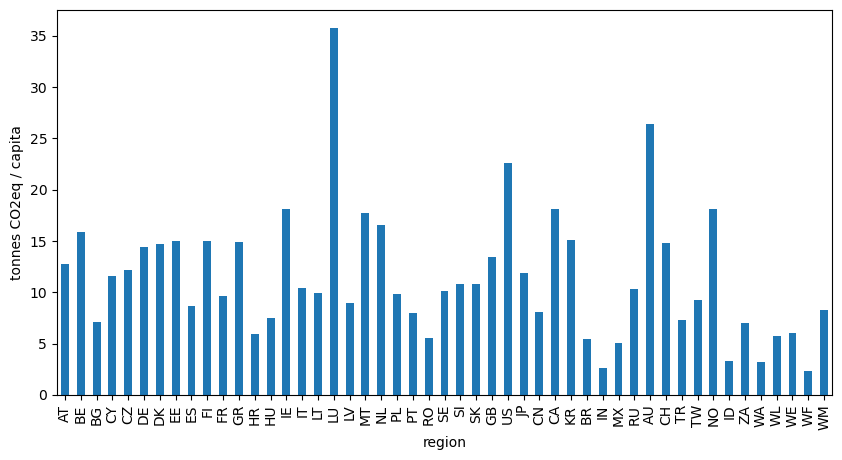

In [18]:
(e_fp_agg_gwp100_pp_region / 1e3).plot(
    figsize = (10,5),
    kind = 'bar',
    ylabel = "tonnes CO2eq / capita",
)

# Check units are indeed in kg
# F_unit.loc[GHG]

#### 1.3 What is the proportion of CO2 emissions in CO2eq in each region's carbon footprint measured in CO2e? (4 points)

In [19]:
# Since Characterization of CO2 = 1, we simply need to divide Q1_1 by Q1_2
e_fp_agg_co2_pp_regions / e_fp_agg_gwp100_pp_region

region
AT   0.77
BE   0.74
BG   0.72
CY   0.84
CZ   0.79
DE   0.81
DK   0.79
EE   0.76
ES   0.72
FI   0.68
FR   0.72
GR   0.84
HR   0.68
HU   0.73
IE   0.65
IT   0.73
LT   0.68
LU   0.65
LV   0.67
MT   0.73
NL   0.74
PL   0.75
PT   0.69
RO   0.69
SE   0.71
SI   0.70
SK   0.71
GB   0.72
US   0.82
JP   0.84
CN   0.80
CA   0.78
KR   0.81
BR   0.45
IN   0.63
MX   0.69
RU   0.77
AU   0.71
CH   0.76
TR   0.71
TW   0.74
NO   0.75
ID   0.55
ZA   0.80
WA   0.65
WL   0.63
WE   0.63
WF   0.37
WM   0.79
dtype: float64

## Question 2: Territorial emissions (6 points)

#### 2.1 What were the per capita territorial emissions of the US and China, respectively, in 2015? Only consider CO2 emissions here. (6 points)

$\mathbf{e}_{\text{PBA}} = \mathbf{\hat{f}X}$  
$\mathbf{e}_{\text{territorial}} = \mathbf{\hat{f}X} + \text{F}_{y}$  

In [20]:
f_co2 = f.loc[CO2]
F_y_co2 = F_y.loc[CO2]

# compute production based emissions
diagfX_co2 = f_co2 * x  # f * x = np.diag(f) @ x

# Uncomment to display result
diagfX_co2

region                                                                AT  \
sector                                         Cultivation of paddy rice   
stressor                                                                   
CO2 - combustion - air                                              0.00   
CO2 - non combustion - Cement production - air                      0.00   
CO2 - non combustion - Lime production - air                        0.00   
CO2 - agriculture - peat decay - air                                0.00   
CO2 - waste - biogenic - air                                        0.00   
CO2 - waste - fossil - air                                          0.00   

region                                                               \
sector                                         Cultivation of wheat   
stressor                                                              
CO2 - combustion - air                               211,616,333.64   
CO2 - non combustion - Cement production - air                 0.00   
CO2 - non combustion - Lime production - air                   0.00   
CO2 - agriculture - peat decay - air                  17,430,494.94   
CO2 - waste - biogenic - air                                   0.00   
CO2 - waste - fossil - air                                     0.00   

region                                                                           \
sector                                         Cultivation of cereal grains nec   
stressor                                                                          
CO2 - combustion - air                                           208,069,180.71   
CO2 - non combustion - Cement production - air                             0.00   
CO2 - non combustion - Lime production - air                               0.00   
CO2 - agriculture - peat decay - air                              27,928,230.65   
CO2 - waste - biogenic - air                                               0.00   
CO2 - waste - fossil - air                                                 0.00   

region                                                                                 \
sector                                         Cultivation of vegetables, fruit, nuts   
stressor                                                                                
CO2 - combustion - air                                                  86,428,667.82   
CO2 - non combustion - Cement production - air                                   0.00   
CO2 - non combustion - Lime production - air                                     0.00   
CO2 - agriculture - peat decay - air                                     7,457,726.38   
CO2 - waste - biogenic - air                                                     0.00   
CO2 - waste - fossil - air                                                       0.00   

region                                                                   \
sector                                         Cultivation of oil seeds   
stressor                                                                  
CO2 - combustion - air                                    38,039,348.57   
CO2 - non combustion - Cement production - air                     0.00   
CO2 - non combustion - Lime production - air                       0.00   
CO2 - agriculture - peat decay - air                       8,401,106.14   
CO2 - waste - biogenic - air                                       0.00   
CO2 - waste - fossil - air                                         0.00   

region                                                                                \
sector                                         Cultivation of sugar cane, sugar beet   
stressor                                                                               
CO2 - combustion - air                                                 11,830,326.03   
CO2 - non combustion - Cement production - air                                  0.00   
CO2 - non

In [21]:
# keep the country (column, level 0), and sum accross final consumption categories (columns level 1)
e_territorial_co2_regions = diagfX_co2.groupby('region', axis=1).sum() + F_y_co2.groupby('region', axis=1).sum()
e_territorial_co2_regions = e_territorial_co2_regions.reindex(columns=region_labels)  # always reorder after groupby

# ! diagfX + F_y --> WRONG !! We need to aggregate diagfX first
# if not (diagfX_co2.shape == F_y_co2.shape):
#     raise IndexError("shape error")

# Display result
e_territorial_co2_regions

region,AT,BE,BG,CY,CZ,DE,DK,EE,ES,FI,...,TR,TW,NO,ID,ZA,WA,WL,WE,WF,WM
stressor,,,,,,,,,,,,,,,,,,,,,
CO2 - combustion - air,"60,382,345,962.46","93,114,246,851.21","42,377,385,903.10","11,565,025,054.66","101,154,728,622.92","866,966,880,333.48","53,414,412,371.21","15,269,102,865.06","264,110,808,888.86","46,003,086,470.11",...,"323,437,305,601.29","254,072,559,585.62","61,044,273,576.96","449,202,980,626.14","384,484,385,159.83","1,710,770,760,452.56","781,534,996,412.15","329,397,760,364.75","624,508,768,506.53","2,074,596,495,817.75"
CO2 - non combustion - Cement production - air,"1,700,000,000.00","2,350,000,000.00","1,100,000,000.00","877,000,000.00","1,560,000,000.00","12,599,999,999.95","932,000,000.00","206,000,000.00","9,220,000,000.00","462,000,000.00",...,"32,599,999,999.95","5,130,000,000.00","672,000,000.00","24,500,000,000.00","5,200,000,000.00","92,726,259,790.00","30,221,859,061.04","8,651,349,800.00","50,728,380,957.01","95,602,000,000.02"
CO2 - non combustion - Lime production - air,"635,482,899.48","2,941,023,645.51","673,209,831.77","117,366,775.58","718,963,559.73","4,831,245,952.33","88,236,177.71","24,801,219.95","778,444,791.93","190,077,277.73",...,"6,985,153,356.56","414,779,064.31","115,324,838.29","2,304,697,499.23","2,174,552,270.37","20,648,978,294.23","15,534,071,196.21","7,876,041,938.81","8,258,756,626.81","14,579,653,480.62"
CO2 - agriculture - peat decay - air,"173,000,000.00","40,500,000.00","36,300,000.00","11,200,000.00","94,300,000.00","2,350,000,000.00","64,600,000.00","293,000.00","830,000,000.00","220,000,000.00",...,"2,530,000,000.00","929,000,000.00","6,380,000.00","2,520,000,000.00","273,000,000.00","6,022.52","4,113.11","1,055.76","1,047.36","4,707,017,000.00"
CO2 - waste - biogenic - air,"192,767.91","1,682,627.91","5,465,655.97",0.00,"389,114,478.38",0.00,"3,586,078.92","329,680.88","3,451,447,037.30",0.00,...,"746,992.78",0.60,"86,645.75","146,000,000.00",0.00,"314,275,530.47","153,135,583.57","42,229,636.11","14,046,352.01","413,962.18"
CO2 - waste - fossil - air,232.09,"17,372.09","234,344.03",0.00,"7,885,521.62",0.00,"293,921.08","8,319.12","48,552,962.70",0.00,...,"39,007.22",0.60,354.25,0.00,0.00,"77,991,469.53","8,253,116.43","859,793.89","948,407.99","9,667.82"


In [22]:
# Compute territorial emissions per capita per region per indicator
e_territorial_co2_pp_regions = e_territorial_co2_regions / population_per_region

# Compute territorial emission for the US & China (aggregate all CO2 indicators)
e_territorial_co2_pp_US = e_territorial_co2_pp_regions['US'].sum()
e_territorial_co2_pp_CN = e_territorial_co2_pp_regions['CN'].sum()

# Display results
print(f"US: {int(e_territorial_co2_pp_US)} kg CO2 per capita")
print(f"China: {int(e_territorial_co2_pp_CN)} kg CO2 per capita")

# Sanity check to make sure the CO2 emissions are accounted in kg
# F_unit.loc[CO2]

US: 15955 kg CO2 per capita
China: 7315 kg CO2 per capita


<Axes: xlabel='region', ylabel='tonnes CO2eq / capita'>

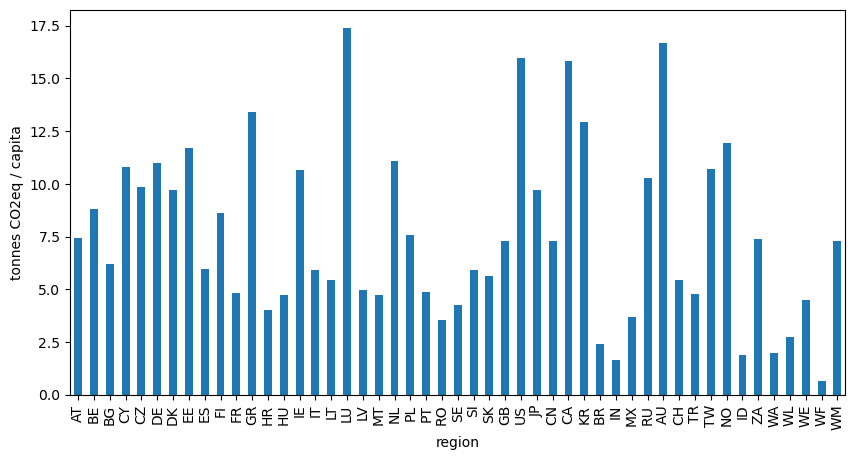

In [23]:
(e_territorial_co2_pp_regions.sum(axis=0) / 1e3).plot(
    figsize = (10,5),
    kind = 'bar',
    ylabel = "tonnes CO2eq / capita",
)

## Question 3: Emissions embodied in trade (20 points)

#### 3.1 Were the US and China net importers or exporters of CO2 emissions in 2015? (4 points)

In [24]:
# Net import
net_import = e_fp_co2_regions - e_territorial_co2_regions

for country in ['US', 'CN']:
    result = net_import[country].sum()
    print(f"{country} Net import: {result} kg CO2")

US Net import: 826367882656.038 kg CO2
CN Net import: -1194159020929.0857 kg CO2


In [39]:
# Alternative method
f_co2_agg = f.loc[CO2].sum()  # sum all CO2 emissions to have a vector
diagfLY_co2_agg = f_co2_agg * LY.T  # = diagf @ L @ Y
diagfLY_co2_agg = diagfLY_co2_agg.T  # retranspose to conserve original layout

# Compute embodied emissions in trade
embodied_emissions_trade_co2 = diagfLY_co2_agg.groupby('region', axis=1).sum()
embodied_emissions_trade_co2 = embodied_emissions_trade_co2.groupby('region', axis=0).sum()

# Display intermediary results
embodied_emissions_trade_co2

region,AT,AU,BE,BG,BR,CA,CH,CN,CY,CZ,...,SK,TR,TW,US,WA,WE,WF,WL,WM,ZA
region,,,,,,,,,,,,,,,,,,,,,
AT,"30,668,774,973.77","193,990,898.41","164,053,158.88","54,982,934.13","186,585,900.09","249,197,990.88","459,083,569.37","1,005,286,813.32","13,711,199.28","257,552,830.35",...,"182,047,480.91","213,392,506.65","99,788,516.53","1,418,095,784.67","604,634,422.04","161,476,312.43","267,941,900.41","494,999,058.14","748,335,984.29","54,707,252.15"
AU,"298,588,431.41","261,088,313,003.42","639,418,369.98","40,431,809.57","1,086,087,180.71","1,257,497,258.11","611,569,107.94","19,659,101,670.96","35,807,727.74","154,030,879.46",...,"72,274,272.60","632,952,665.33","1,333,023,856.27","9,344,378,683.27","10,804,671,455.31","253,188,552.29","1,354,926,190.50","2,282,131,444.78","5,067,332,090.69","314,180,164.75"
BE,"378,011,742.18","439,851,024.08","34,719,874,559.62","57,835,187.37","559,890,491.22","523,102,884.58","651,663,456.57","3,151,973,210.25","30,966,040.45","222,374,034.48",...,"86,950,803.98","537,787,249.52","132,252,496.31","3,533,997,612.64","1,481,118,877.01","253,251,002.45","1,486,041,500.74","1,264,307,974.18","1,779,436,371.51","166,483,606.24"
BG,"253,275,023.45","146,038,423.66","228,805,534.66","19,805,230,932.29","141,289,651.40","161,752,416.31","161,580,872.80","1,139,583,314.79","72,930,921.34","187,052,145.45",...,"107,003,817.81","1,572,946,137.90","125,665,639.66","1,014,244,053.28","1,819,170,824.54","593,193,178.91","574,240,804.87","385,193,882.05","1,759,173,816.47","62,488,050.63"
BR,"204,337,258.43","611,772,466.32","640,024,499.60","39,072,761.14","310,176,052,127.56","1,404,679,624.82","536,376,040.05","16,538,480,267.57","15,663,767.42","132,923,408.90",...,"55,489,969.19","819,232,398.01","2,315,955,017.07","16,653,221,116.16","5,200,304,357.97","290,205,802.30","2,222,930,702.80","27,779,983,694.74","6,267,057,825.95","142,794,661.91"
CA,"420,610,310.18","1,199,150,667.12","961,833,992.32","48,189,267.29","1,488,163,195.35","238,233,793,472.14","748,549,106.11","12,093,670,742.38","36,517,859.25","260,668,820.82",...,"102,359,429.98","800,774,929.54","1,097,445,136.75","134,492,590,587.59","4,553,292,376.49","433,002,068.48","1,731,794,348.79","10,442,301,642.13","3,149,649,865.69","280,370,043.09"
CH,"151,030,723.05","187,232,750.62","173,203,079.08","12,862,012.66","227,176,143.68","217,773,520.76","15,004,301,638.00","1,060,036,945.13","10,591,048.79","51,900,887.44",...,"21,000,909.68","141,512,779.69","68,240,623.08","1,518,609,165.58","562,460,244.17","108,238,252.55","285,429,268.67","366,760,719.17","675,407,952.52","76,607,091.15"
CN,"4,383,563,788.11","38,569,031,067.47","12,364,127,166.64","1,027,079,266.04","29,256,654,469.79","32,814,788,647.74","7,913,825,365.27","7,495,721,360,568.99","336,355,965.05","4,181,585,631.03",...,"1,789,830,170.05","21,744,553,357.60","4,190,284,104.56","397,012,889,795.49","453,402,120,290.08","5,266,152,692.80","73,213,589,555.21","149,184,119,524.17","157,510,353,234.17","3,540,160,377.69"
CY,"66,395,733.17","148,288,572.64","61,140,956.18","10,816,092.35","137,049,664.31","109,669,854.32","94,150,701.39","370,793,595.51","6,068,998,882.90","21,288,386.65",...,"15,542,769.44","119,893,626.91","56,627,109.92","342,961,273.56","119,671,372.30","28,931,522.59","65,588,309.11","88,663,616.57","834,877,809.79","20,059,868.04"


In [40]:
# Compute imported / exported emissions
exports = embodied_emissions_trade_co2.sum(axis=1)  # add columns to get exported emissions
imports = embodied_emissions_trade_co2.sum(axis=0)  # add rows to get imported emissions

(imports- exports)[['US', 'CN']]

region
US      826,367,882,656.04
CN   -1,194,159,020,929.09
dtype: float64

#### 3.2 Which were the top three regional contributers of US' and China's carbon footprints (only consider CO2 emissions), respectively, in 2015? (12 points)

In [26]:
# Display top regional contributers to China's carbon footprint
embodied_emissions_trade_co2['CN'].nlargest(3)

region
CN   7,495,721,360,568.99
WA     182,418,519,314.71
WM      94,509,262,937.82
Name: CN, dtype: float64

<Axes: ylabel='CN'>

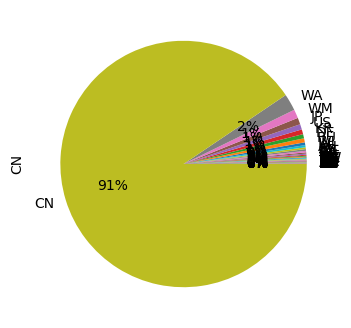

In [27]:
embodied_emissions_trade_co2['CN'].sort_values().plot(
    figsize = (6,4),
    kind = 'pie',
    autopct = '%1.0f%%',
)

In [28]:
# Display top regional contributers to US's carbon footprint
embodied_emissions_trade_co2['US'].nlargest(3)

region
US   3,195,042,580,125.75
CN     397,012,889,795.49
CA     134,492,590,587.59
Name: US, dtype: float64

<Axes: ylabel='US'>

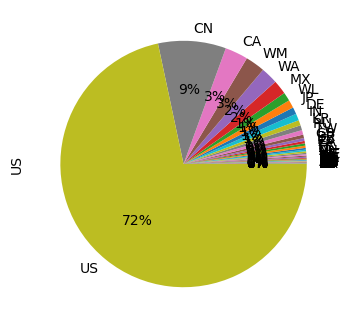

In [29]:
embodied_emissions_trade_co2['US'].sort_values().plot(
    figsize = (6,4),
    kind = 'pie',
    autopct = '%1.0f%%',
)

#### 3.3 By conducting emissions emoboided in trade calculations, how much CO2 emissions did the US outsourced to China in 2015? (4 points)

In [30]:
# Show the trade balance (CO2) between the US and China
embodied_emissions_trade_co2.loc['CN', 'US'] - embodied_emissions_trade_co2.loc['US', 'CN']

338843690649.1221

## Question 4 Environmental vs Economic Footprints Analysis (16 points)

#### 4.1 Using the "impact" accounts, what were the value added footrpints of the US and China, respectively, in 2015? (8 points)

In [31]:
# import 'impact > F'
F_impacts = pd.read_csv(f'{dir_path}impacts/F.txt', delimiter="\t", header=[0,1], index_col=[0])
F_impacts_unit = pd.read_csv(f'{dir_path}impacts/unit.txt', delimiter="\t", header=0, index_col=[0])

# and find the Value Added index:
MASK = F_impacts.index.str.contains("Value Added")
VA = F_impacts.loc[MASK].index
VA

Index(['Value Added'], dtype='object', name='impact')

In [32]:
# compute new extension intensity
f_impacts = F_impacts / x.T
f_impacts = f_impacts.replace([np.inf, -np.inf, np.nan], 0)  # ! don't forget to replace

# Uncomment to visualise
f_impacts.loc[VA]

region                             AT                       \
sector      Cultivation of paddy rice Cultivation of wheat   
impact                                                       
Value Added                      0.00                 0.68   

region                                        \
sector      Cultivation of cereal grains nec   
impact                                         
Value Added                             0.73   

region                                                                       \
sector      Cultivation of vegetables, fruit, nuts Cultivation of oil seeds   
impact                                                                        
Value Added                                   0.69                     0.82   

region                                             \
sector      Cultivation of sugar cane, sugar beet   
impact                                              
Value Added                                  0.67   

region                                                                  \
sector      Cultivation of plant-based fibers Cultivation of crops nec   
impact                                                                   
Value Added                              0.93                     0.68   

region                                   ...                       WM  \
sector      Cattle farming Pigs farming  ... Landfill of waste: Paper   
impact                                   ...                            
Value Added          -0.03         0.44  ...                     0.31   

region                                  \
sector      Landfill of waste: Plastic   
impact                                   
Value Added                       0.11   

region                                                \
sector      Landfill of waste: Inert/metal/hazardous   
impact                                                 
Value Added                                     0.32   

region                                                           \
sector      Landfill of waste: Textiles Landfill of waste: Wood   
impact                                                            
Value Added                        0.32                    0.32   

region                                                         \
sector      Activities of membership organisation n.e.c. (91)   
impact                                                          
Value Added                                              0.44   

region                                                           \
sector      Recreational, cultural and sporting activities (92)   
impact                                                            
Value Added                                               0.49    

region                                     \
sector      Other service activities (93)   
impact                                      
Value Added                          0.50   

region                                                     \
sector      Private households with employed persons (95)   
impact                                                      
Value Added                                          0.69   

region                                                  
sector      Extra-territorial organizations and bodies  
impact                                                  
Value Added                                       0.00  

[1 rows x 7987 columns]

In [33]:
# proceed as usual
fLY_impacts = f_impacts @ LY

fLY_impacts_regions = fLY_impacts.groupby("region", axis=1).sum()  # keep regions, add final consumption categories
fLY_impacts_regions = fLY_impacts_regions.reindex(columns=region_labels)  # reindex after groupby

# Display the result
countries = ['US', 'CN']
fLY_impacts_regions.loc[VA, countries]

region,US,CN
impact,,
Value Added,"16,912,908.54","9,647,962.28"


In [34]:
# Display value added per capita
print("units in euros per capita (instead of million euros per capita)\n")
1e6*(fLY_impacts_regions / population_per_region).loc[VA, countries]

units in euros per capita (instead of million euros per capita)



region,US,CN
impact,,
Value Added,"52,445.89","7,107.78"


#### 4.2 Make two main observations on the carbon vs value added footprint results regarding the relationships between the US and China? Please refer to the carbon footprint results obtained in Question 1 (8 points)

In [35]:
f_va = f_impacts.loc[VA].sum()  # we need a vector (i.e. pd.Series) before diagonalizing

diagfLY_va = f_va * LY.T  # = diagf @ L @ Y
diagfLY_va = diagfLY_va.T  # retranspose to conserve original layout

# Compute embodied value added in trade
embodied_VA_trade = diagfLY_va.groupby('region', axis=1).sum()
embodied_VA_trade = embodied_VA_trade.groupby('region', axis=0).sum()

# Uncomment to display result
# embodied_VA_trade

In [36]:
# Show the trade balance (Value Added) between the US and China
embodied_VA_trade.loc['CN', 'US'] - embodied_VA_trade.loc['US', 'CN']

# Check Unit to make sure it's in Million euros
# F_impacts_unit.loc[VA]

125352.43557258381

<Axes: ylabel='US'>

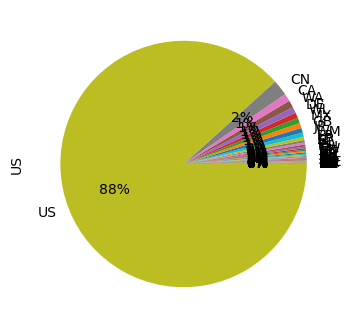

In [37]:
embodied_VA_trade['US'].sort_values().plot(
    figsize = (6,4),
    kind = 'pie',
    autopct = '%1.0f%%',
)

<Axes: ylabel='CN'>

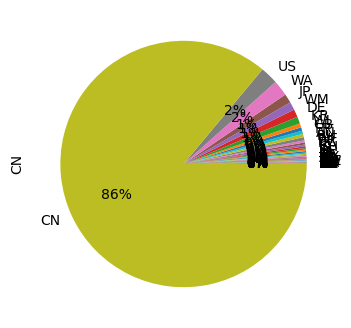

In [38]:
embodied_VA_trade['CN'].sort_values().plot(
    figsize = (6,4),
    kind = 'pie',
    autopct = '%1.0f%%',
)